<a href="https://colab.research.google.com/github/plaban1981/pytorch-lightning/blob/master/PyTorch_Lightning_Kickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install required Libraries

In [2]:
%%bash
pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
%%bash
pip install -q -U watermark

In [6]:
%reload_ext watermark

In [12]:
import pytorch_lightning as pl
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
import pandas as pd
import numpy as np
import seaborn as sns
from torch.autograd import Variable
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy

* The torch package is used for defining tensors and for performing mathematical operations on the tensors. 
* The torch.nn package is used for constructing neural networks, which is what nn stands for. 
* torch.nn.functional contains functions including activation and loss functions.
* torchvision.transforms is a separate library that provides common image transformations. O

In [9]:
%watermark -v -p torch,pytorch_lightning

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 7.9.0

torch            : 1.13.0+cu116
pytorch_lightning: 1.8.6



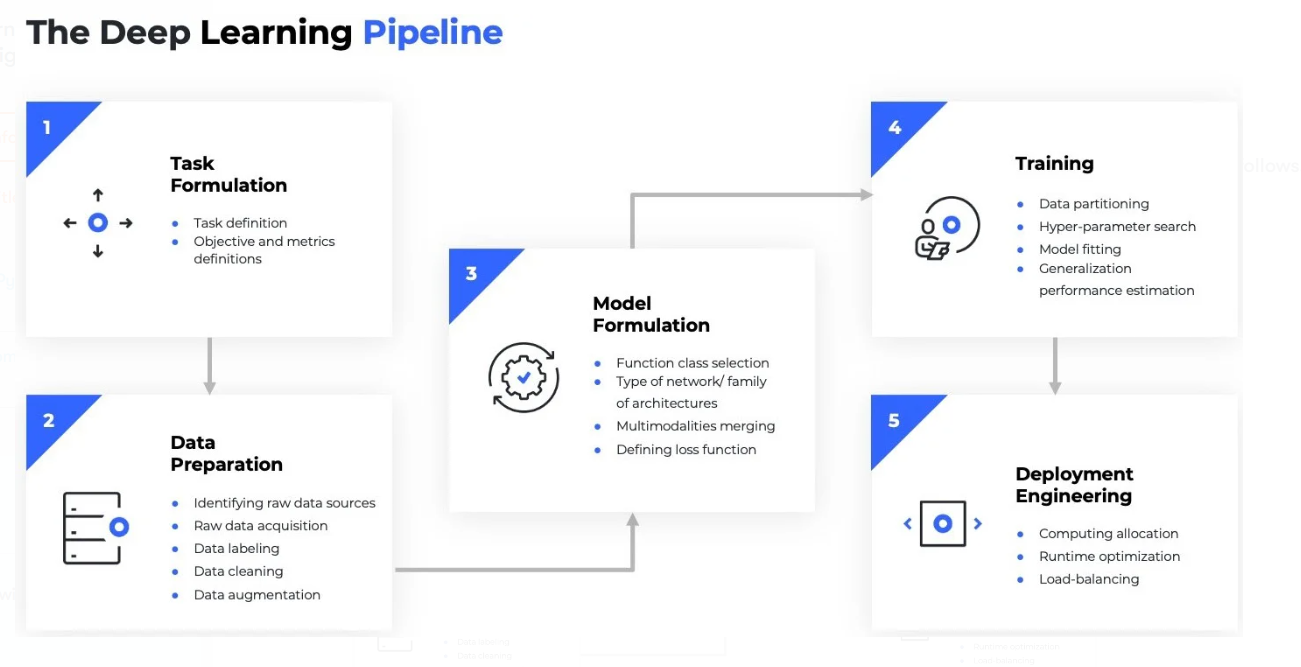

## PyTorch Lightning abstraction layers

* **LightningModule class** is used to define the model structure, inference logic, optimizer and scheduler details, training and validation logic, and so on.

* **Lightning Trainer** abstracts the logic needed for loops, hardware interactions, fitting and evaluating the model, and so on.

* Pass a **PyTorch DataLoader** to the trainer directly, or 
* choose to define a **LightningDataModule** for improved shareability and reuse.

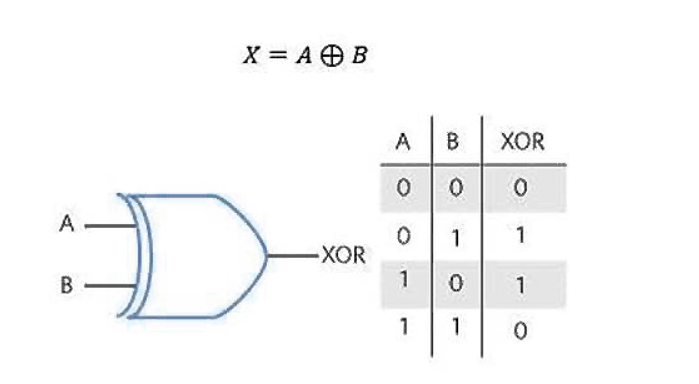

In [13]:
xor_input = [Variable(torch.Tensor([0, 0])),
           Variable(torch.Tensor([0, 1])),
           Variable(torch.Tensor([1, 0])),
           Variable(torch.Tensor([1, 1]))]

In [14]:
xor_target = [Variable(torch.Tensor([0])),
           Variable(torch.Tensor([1])),
           Variable(torch.Tensor([1])),
           Variable(torch.Tensor([0]))]

In [15]:
xor_data = list(zip(xor_input, xor_target))
train_loader = DataLoader(xor_data, batch_size=1000)

In [16]:
next(iter(train_loader))

[tensor([[0., 0.],
         [0., 1.],
         [1., 0.],
         [1., 1.]]), tensor([[0.],
         [1.],
         [1.],
         [0.]])]

In [19]:
from torch import nn, optim

* **Initializing the model:**
    
    * Begin by creating a class called XOR that inherits from PyTorch LightningModule
    * Start creating our layers using the __init__() method to set up hidden layers,initialize activation function,initialize loss function.
    * Mapping inputs to the model.This is a simple step where we are using the forward method, which takes the inputs and generates the model's output.
    * The forward method acts as a mapper or medium where data is passed between multiple layers and the activation function.
    * All models built in PyTorch Lightning can be trained using a **Trainer class**. 
The Trainer class is an abstraction of some key things, such as looping over the dataset, backpropagation, clearing gradients, and the optimizer step

In [20]:
class XORModel(pl.LightningModule):
  def __init__(self):

    super(XORModel,self).__init__()
    
    self.input_layer = nn.Linear(2, 4)
    self.output_layer = nn.Linear(4,1)

    self.sigmoid = nn.Sigmoid()

    self.loss = nn.MSELoss()

  def forward(self, input):
    #print("INPUT:", input.shape)
    x = self.input_layer(input)
    #print("FIRST:", x.shape)
    x = self.sigmoid(x)
    #print("SECOND:", x.shape)
    output = self.output_layer(x)
    #print("THIRD:", output.shape)
    return output

  def configure_optimizers(self):
    params = self.parameters()
    optimizer = optim.Adam(params=params, lr = 0.01)
    return optimizer

  def training_step(self, batch, batch_idx):
    xor_input, xor_target = batch
    #print("XOR INPUT:", xor_input.shape)
    #print("XOR TARGET:", xor_target.shape)
    outputs = self(xor_input) 
    #print("XOR OUTPUT:", outputs.shape)
    loss = self.loss(outputs, xor_target)
    return loss 

In [26]:
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS
checkpoint_callback = ModelCheckpoint()
model = XORModel()

trainer = pl.Trainer(max_epochs=500, callbacks=[checkpoint_callback])

trainer.fit(model, train_dataloaders=train_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type    | Params
-----------------------------------------
0 | input_layer  | Linear  | 12    
1 | output_layer | Linear  | 5     
2 | sigmoid      | Sigmoid | 0     
3 | loss         | MSELoss | 0     
-----------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=500` reached.


* In PyTorch Lightning, **one advantage we see is whenever we train a model multiple times, all the different model versions are saved to disk in a default folder called lightning_logs**, and once all the models with different versions are made ready, we always have the opportunity to load the different model versions from the files and compare the results. 

In [34]:
ls lightning_logs/

version_0/  version_1/


## Loading the model
* Once we have built the model, the next step is to load that model. 
* identifying the latest version of a model can be done using checkpoint_callback, created in the preceding step.

In [27]:
print(checkpoint_callback.best_model_path)

/content/lightning_logs/version_1/checkpoints/epoch=499-step=500.ckpt


In [28]:
train_model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
test = torch.utils.data.DataLoader(xor_input, batch_size=1)
for val in xor_input:
  _ = train_model(val)
  print([int(val[0]),int(val[1])], int(_.round()))

[0, 0] 0
[0, 1] 1
[1, 0] 1
[1, 1] 0


## Making predictions

In [32]:
print(checkpoint_callback.best_model_path)
train_model = model.load_from_checkpoint(checkpoint_callback.best_model_path)
total_accuracy = []
for xor_input, xor_target in train_loader:
  for i in range(100):
    output_tensor = train_model(xor_input)
    test_accuracy = accuracy(preds=output_tensor, target=xor_target.int(),task='binary')
    total_accuracy.append(test_accuracy)
total_accuracy = torch.mean(torch.stack(total_accuracy))
print("TOTAL ACCURACY FOR 100 ITERATIONS: ", total_accuracy.item())

/content/lightning_logs/version_1/checkpoints/epoch=499-step=500.ckpt
TOTAL ACCURACY FOR 100 ITERATIONS:  1.0
